In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

## Ridge Regression Using Newton's Method

In [2]:
# Newton's method for ridge regression
def ridge_regression_newton(X, y, lambda_, max_iter=20, tol=1e-9):

    # Start timing
    start_time = time.perf_counter()

    #Initializations
    n_features = X.shape[1]
    beta = np.zeros(n_features)
    convergence = []
    r2_scores = []
    mae_scores = []
    rmse_scores = []

    # Compute Hessian
    hessian = X.T @ X + lambda_ * np.eye(n_features)

    for iteration in range(max_iter):
        # Calculate predictions
        predictions = X @ beta

        # Compute residuals
        residuals = y - predictions

        # Compute gradient
        gradient = -X.T @ residuals + lambda_ * beta

        # Update beta using Newton's method
        beta_update = np.linalg.solve(hessian, gradient)
        beta -= beta_update

        # Track convergence
        grad_norm = np.linalg.norm(beta_update, ord=2)
        convergence.append(grad_norm)

        # Track metrics
        r2_scores.append(r2_score(y, predictions))
        mae_scores.append(mean_absolute_error(y, predictions))
        rmse_scores.append(np.sqrt(mean_squared_error(y, predictions)))

        # Check for convergence
        if grad_norm < tol:
            print(f"Converged in {iteration} iterations.")
            break
    else:
        print("Newton's Method did not converge within the maximum number of iterations.")

    # Stop timing
    end_time = time.perf_counter()
    time_newton = end_time - start_time

    return beta, convergence, r2_scores, mae_scores, rmse_scores, time_newton

In [3]:
# Closed form solution for ridge regression
def ridge_regression_closed_form(X, y, lambda_):
    # Start timing
    start_time = time.perf_counter()

    n_features = X.shape[1]
    I = np.eye(n_features)
    ret = np.linalg.inv(X.T @ X + lambda_ * I) @ X.T @ y

    # Stop timing
    end_time = time.perf_counter()
    time_closed = end_time - start_time

    return ret, time_closed

## Reading Cleaned Data

In [4]:
# Read in cleaned data
features_train = pd.read_csv('X_train.csv', index_col = 0)
features_test = pd.read_csv('X_test.csv', index_col = 0)
labels_train = pd.read_csv('y_train.csv', index_col = 0).squeeze()
labels_test = pd.read_csv('y_test.csv', index_col = 0).squeeze()

In [5]:
# Shape of features matrix
np.shape(features_train)

(41331, 1254)

In [6]:
# Rank of features matrix
np.linalg.matrix_rank(features_train)

np.int64(1182)

Since rank = 1182 < columns = 1254, our features matrix is rank deficient. Perform SVD and only keep the linearly independent columns of our features matrix to ensure we can calculate the inverse of its Hessian later on in Newton's method.

In [7]:
def perform_svd(train_data, test_data):
    # Start timing
    start_time = time.perf_counter()

    # Perform SVD to remove linearly dependent columns
    U, S, Vt = np.linalg.svd(train_data, full_matrices=False)

    # Determine linearly independent columns
    rank = np.sum(S > 1e-10)
    independent_columns = Vt[:rank, :]

    # Reduce the training data to only linearly independent columns
    train_new = train_data @ independent_columns.T

    # Stop timing
    end_time = time.perf_counter()
    time_svd = end_time - start_time

    # Reduce the testing data to be the same columns as the training data
    test_new = test_data @ independent_columns.T

    print("Shape of training data after SVD:", np.shape(train_new))
    print("Shape of testing data after SVD:", np.shape(test_new))
    print(f"SVD Reduction Run Time (s): {time_svd:.2f}")

    return train_new, test_new, time_svd

In [8]:
# Remove linearly dependent columns from training and testing data
X_train_reduced, X_test_reduced, time_svd = perform_svd(features_train, features_test)

Shape of training data after SVD: (41331, 1182)
Shape of testing data after SVD: (27554, 1182)
SVD Reduction Run Time (s): 9.53


In [9]:
# Shape of reduced features matrix with only linearly independent columns
np.shape(X_train_reduced)

(41331, 1182)

In [10]:
# Extract features (X) and target (y)
X_train = X_train_reduced
y_train = labels_train
X_test = X_test_reduced
y_test = labels_test

In [11]:
# Add a column of ones to X for the intercept
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

## Training Newton's Method Ridge Regression

In [12]:
# Set regularization parameter
lambda_ = .5

# Fit the model using Ridge Regression with Newton's Method
beta_newton, convergence_newton, r2_scores_newton, mae_scores_newton, rmse_scores_newton, time_newton = ridge_regression_newton(X_train, y_train, lambda_=lambda_)

# Print results
print("Newton's Method Training Results")
print("\n----------\n")
print(f"Newton's Method Run Time (s): {time_newton:.2f}")
print(f"SVD Reduction Run Time (s): {time_svd:.2f}")
print(f"Total Run Time (s): {(time_newton + time_svd):.2f}")
print("\n----------\n")
print(f"The R squared of Newton's method is: {r2_scores_newton[-1]:.2f}")
print(f"The Mean Absolute Error (MAE) of Newton's method is: {mae_scores_newton[-1]:.2f}")
print(f"The Root Mean Squared Error (RMSE) of Newton's method is: {rmse_scores_newton[-1]:.2f}")

Newton's Method did not converge within the maximum number of iterations.
Newton's Method Training Results

----------

Newton's Method Run Time (s): 3.96
SVD Reduction Run Time (s): 9.53
Total Run Time (s): 13.49

----------

The R squared of Newton's method is: 0.63
The Mean Absolute Error (MAE) of Newton's method is: 180407.22
The Root Mean Squared Error (RMSE) of Newton's method is: 262774.68


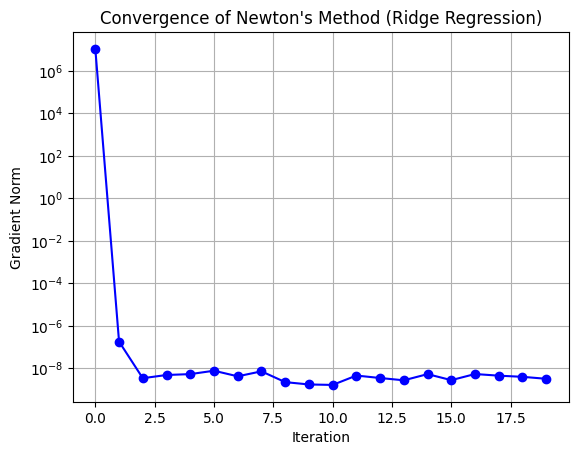

In [13]:
# Plot convergence
plt.figure()
plt.plot(convergence_newton, marker='o', linestyle='-', color='b')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Convergence of Newton\'s Method (Ridge Regression)')
plt.grid(True)
plt.show()

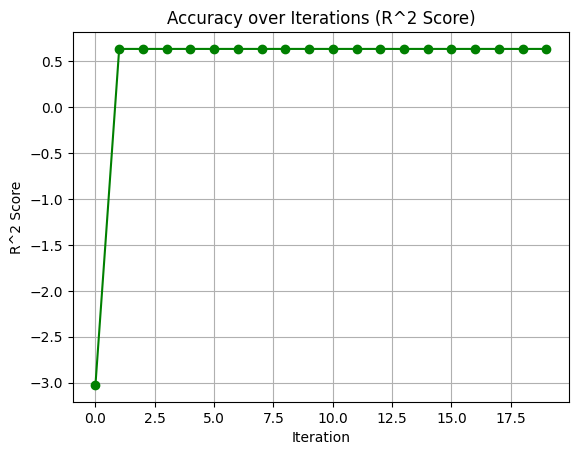

In [14]:
# Plot accuracy
plt.figure()
plt.plot(r2_scores_newton, marker='o', linestyle='-', color='g')
plt.xlabel('Iteration')
plt.ylabel('R^2 Score')
plt.title('Accuracy over Iterations (R^2 Score)')
plt.grid(True)
plt.show()

## Comparing to Closed-Form Solution

In [15]:
# Compute the closed-form solution
beta_closed_form, time_closed = ridge_regression_closed_form(X_train, y_train, lambda_)

In [16]:
# Print and compare both solutions
print("Beta from Newton's Method:", beta_newton)
print("Beta from Closed-Form Solution:", beta_closed_form)

# Check the difference
difference = np.linalg.norm(beta_newton - beta_closed_form)
print("Difference between Newton's Method and Closed-Form Solution:", difference)

Beta from Newton's Method: [ 4.96055532e+05 -5.19601360e+01  2.49135813e+05 ...  4.31981708e+05
  5.46174707e+05 -1.20774341e+05]
Beta from Closed-Form Solution: [ 4.96055532e+05 -5.19601360e+01  2.49135813e+05 ...  4.31981708e+05
  5.46174707e+05 -1.20774341e+05]
Difference between Newton's Method and Closed-Form Solution: 5.860175051766509e-07


In [17]:
# Compute metrics for Closed-Form Solution
predictions_closed = X_train @ beta_closed_form
r2_closed = r2_score(y_train, predictions_closed)

In [18]:
print("Method Comparison:")
print("-------------------------------------------------")
print(f"{'Metric':<20} {'Newton':<15} {'Closed-Form':<15}")
print(f"{'R² Score':<20} {r2_scores_newton[-1]:<15.4f} {r2_closed:<15.4f}")
print(f"{'Execution Time (s)':<20} {time_newton:<15.6f} {time_closed:<15.6f}")

Method Comparison:
-------------------------------------------------
Metric               Newton          Closed-Form    
R² Score             0.6345          0.6345         
Execution Time (s)   3.964150        1.638431       


## Testing Results

In [19]:
def test_model(beta, X_test, y_test):
    # Make predictions
    y_pred_test = X_test @ beta

    # Print results
    print("Newton's Method Testing Results")
    print("\n----------\n")
    print(f"The R squared of Newton's method is: {r2_score(y_test, y_pred_test):.2f}")
    print(f"The Mean Absolute Error (MAE) of Newton's method is: {mean_absolute_error(y_test, y_pred_test):.2f}")
    print(f"The Root Mean Squared Error (RMSE) of Newton's method is: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")

In [20]:
test_model(beta_newton, X_test, y_test)

Newton's Method Testing Results

----------

The R squared of Newton's method is: 0.61
The Mean Absolute Error (MAE) of Newton's method is: 187181.66
The Root Mean Squared Error (RMSE) of Newton's method is: 273822.51
